## Analyze clusters among anomalies
The clustering approach can help to gain insight into the model by grouping the anomalous spectra into clusters based on their similarity in terms of the weights assigned by the LIME algorithm. This can help identify patterns or trends in the explanations that may not be immediately apparent from the weights alone.

For example, certain clusters might have higher explanation weights for certain wavelength ranges, or certain clusters have higher explanation weights overall. This can help to understand which features of the spectra are most important for the model's predictions, and can potentially uncover new scientific insights.

Additionally, by plotting the mean spectrum and mean explanation weights for each cluster, I can get a sense of how the model is using different features of the spectra to make its predictions, and identify any patterns or trends in the model's behavior that may be relevant to the anomaly detection task.

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from astroExplain.spectra.explanation import TellMeWhy
from anomaly.constants import GALAXY_LINES

In [10]:
# directories for data
bin_id = "bin_03"
user = "/home/edgar"
work_directory = f"{user}/spectra/0_01_z_0_5_4_0_snr_inf"
model = "256_128_64/latent_12"
iml_use_case_directory = (
    f"{user}/explain-me-why/sections/figures/iml_use_cases"
)

region_directory = (
    f"{iml_use_case_directory}/cluster_regions_of_interest/"
    "weights_all_abs"
)

# metric = "mse_filter_250kms_noRel97"
metric = "mse_noRel100"
# metric = "mse_filter_250kms_noRel100"
# metric = "mse_noRel97"
# metric = "mse_filter_250kms_rel100"
# metric = "mse_filter_250kms_rel97"
# metric = "mse_rel100"
# metric = "mse_rel97"
data_directory = (
    f"{work_directory}/{bin_id}/explanation/"
    f"{model}/{metric}"
)

In [3]:
wave = np.load(f"{work_directory}/wave_spectra_imputed.npy")
anomalies = np.load(f"{data_directory}/top_anomalies.npy")
df_anomalies = pd.read_csv(
    f"{data_directory}/top_anomalies.csv.gz", index_col="specobjid"
)

# load the weights
explanation_weights = np.load(
    f"{data_directory}/explanation_weights/weights_all_abs_"
    f"smooth_True_drop_0.05_{metric}_bin_03.npy"
)

In [4]:
explanation_weights.min(), explanation_weights.max()

(0.0, 1.0)

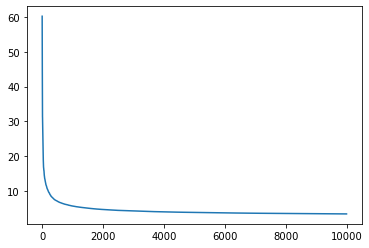

In [5]:
# sort scores in descending order in place in the df
df_anomalies.sort_values(by="score", ascending=False, inplace=True)
# reverse spectra in anomalies array as well
anomalies = anomalies[::-1]
plt.plot(df_anomalies["score"].to_numpy())

# Inspect spectra in clusters

In [6]:
# load the Kmeans model

if metric == "mse_filter_250kms_noRel97":

    metric_name = "MSE ($250$ km~s$^{-1}$, ignore $3\%$)"
    metric_directory = "filter_mse"
    model_name = "kmeans_mse_filter_250kms_noRel97_bin_03.pkl"

elif metric == "mse_noRel100":

    metric_name = "MSE"
    metric_directory = "mse"
    model_name = "kmeans_mse_noRel100_bin_03.pkl"

print(model_name)

with open(f"{region_directory}/{model_name}", "rb") as f:
    kmeans = pickle.load(f)

kmeans_mse_noRel100_bin_03.pkl


## Plot spectra of centroids with its explanation weights

In [7]:
# set dictionary with np.array of anomalies per cluster

cluster_labels = kmeans.labels_

anomalies_per_cluster = {}
weights_per_cluster = {}

for cluster_number in range(kmeans.n_clusters):
    
        anomalies_per_cluster[cluster_number+1] = anomalies[
            cluster_labels == cluster_number
        ]

        weights_per_cluster[cluster_number+1] = explanation_weights[
            cluster_labels == cluster_number
        ]

centroids = kmeans.cluster_centers_
centroid_indices = []

for idx, centroid in enumerate(centroids):

    centroid = centroid.reshape(1, -1)

    distances = np.sum(
        (weights_per_cluster[idx + 1] - centroid)**2,
        axis=1
    )
    index = np.argmin(distances)
    centroid_indices.append(index)
    print(
        weights_per_cluster[idx + 1].min(),
        weights_per_cluster[idx + 1].max(),
        weights_per_cluster[idx + 1].shape
    )


0.0 1.0 (4074, 3773)
0.0 1.0 (1307, 3773)
0.0 1.0 (1003, 3773)
0.0 1.0 (984, 3773)
0.0 1.0 (1369, 3773)
0.0 1.0 (1263, 3773)


In [8]:
centroid_indices
np.unique(cluster_labels)
cluster_labels[centroid_indices]
centroids.max(), centroids.min()

(0.9609295808244531, 0.006013450399051372)

Cluster centroid index: 2260 cluster label: 3
Cluster centroid index: 767 cluster label: 5
Cluster centroid index: 292 cluster label: 3
Cluster centroid index: 212 cluster label: 1
Cluster centroid index: 811 cluster label: 1
Cluster centroid index: 713 cluster label: 5


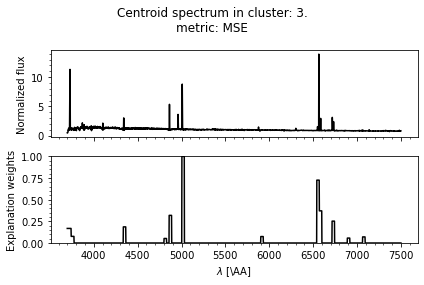

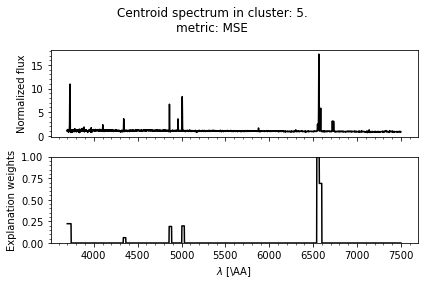

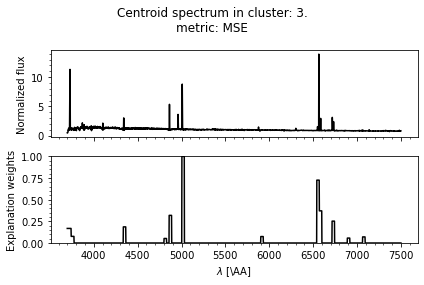

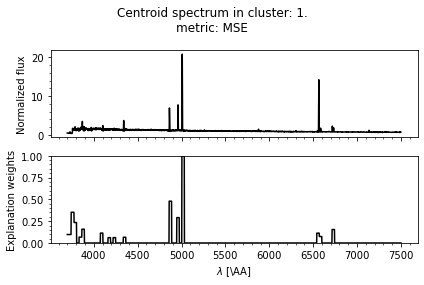

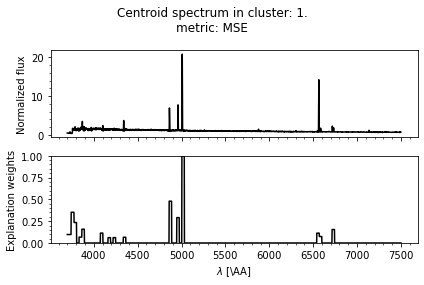

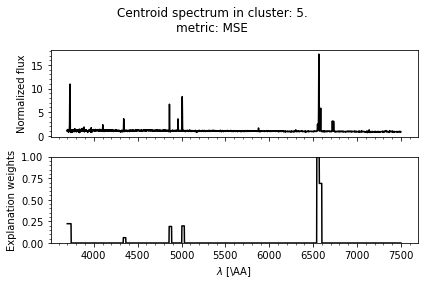

In [9]:
save_directory = f"{region_directory}/{metric_directory}"
cluster_labels = kmeans.labels_

for centroid_index in centroid_indices:

    n_cluster = cluster_labels[centroid_index]

    print(
        f"Cluster centroid index: {centroid_index} "
        f"cluster label: {n_cluster + 1}"
    )

    fig, axs = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=None,
        sharex=True,
        sharey=False,
        tight_layout=True,
    )


    # add title 
    fig.suptitle(
        f"Centroid spectrum in cluster: {n_cluster + 1}.\n"
        f"metric: {metric_name}"
    )
    # set minor ticks on
    for ax in axs.flatten(): ax.minorticks_on()

    # plot spectra and explanation weights of centroid

    axs[0].plot(
        wave, anomalies[centroid_indices[n_cluster]],
        color="black"
    )

    axs[1].plot(
        wave, explanation_weights[centroid_indices[n_cluster]],
        color="black"
    )

    axs[0].set_ylabel("Normalized flux")
    axs[1].set_ylabel("Explanation weights")
    axs[1].set_xlabel("$\lambda$ [\AA]")
    axs[1].set_ylim(0., 1.)

    fig.savefig(
        f"{save_directory}/centroid_spectra_cluster_{n_cluster + 1}.pdf",
    )